In [1]:
!pip install -q darts

     |████████████████████████████████| 253 kB 6.9 MB/s 
     |████████████████████████████████| 10.3 MB 50.4 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 65 kB 1.4 MB/s 
     |████████████████████████████████| 9.8 MB 24.7 MB/s 
     |████████████████████████████████| 1.4 MB 58.4 MB/s 
     |████████████████████████████████| 2.0 MB 26.5 MB/s 
     |████████████████████████████████| 788 kB 73.0 MB/s 
     |████████████████████████████████| 9.9 MB 21.4 MB/s 
     |████████████████████████████████| 62 kB 779 kB/s 
     |████████████████████████████████| 177 kB 65.1 MB/s 
     |████████████████████████████████| 28.5 MB 47 kB/s 
     |████████████████████████████████| 155 kB 59.8 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 374 kB 51.1 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 214 kB 47.0 MB/s 
ERROR: pip's depende

In [2]:
!pip install -q matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 103 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.12.0 requires matplotlib>=3.4.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/airline-passengers.csv')

In [5]:
series = TimeSeries.from_dataframe(df,'Month','Passengers')

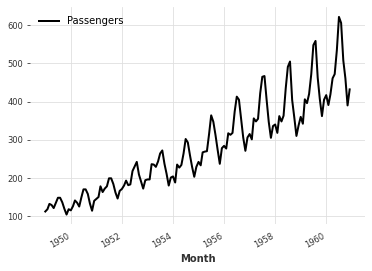

In [6]:
series.plot()

In [7]:
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('19590101'))

In [8]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=500,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=12,
    force_reset=True
)

In [9]:
my_model.fit(train_transformed,
             future_covariates=covariates,
             verbose=True)

[2021-10-22 03:45:16,037] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 101 samples.
[2021-10-22 03:45:16,037] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 101 samples.
[2021-10-22 03:45:16,068] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-22 03:45:16,068] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
  0%|          | 1/500 [00:02<17:42,  2.13s/it]

  2%|▏         | 11/500 [00:22<16:14,  1.99s/it]

  4%|▍         | 21/500 [00:42<15:47,  1.98s/it]

  6%|▌         | 31/500 [01:01<15:33,  1.99s/it]

  8%|▊         | 41/500 [01:21<15:14,  1.99s/it]

 10%|█         | 51/500 [01:41<15:07,  2.02s/it]

 12%|█▏        | 61/500 [02:02<14:45,  2.02s/it]

 14%|█▍        | 71/500 [02:22<14:27,  2.02s/it]

 16%|█▌        | 81/500 [02:42<14:00,  2.01s/it]

 18%|█▊        | 91/500 [03:02<13:46,  2.02s/it]

 20%|██        | 101/500 [03:24<17:16,  2.60s/it]

 22%|██▏       | 111/500 [03:47<13:19,  2.06s/it]

 24%|██▍       | 121/500 [04:07<12:38,  2.00s/it]

 26%|██▌       | 131/500 [04:27<12:29,  2.03s/it]

 28%|██▊       | 141/500 [04:47<12:02,  2.01s/it]

 30%|███       | 151/500 [05:07<11:34,  1.99s/it]

 32%|███▏      | 161/500 [05:27<11:13,  1.99s/it]

 34%|███▍      | 171/500 [05:47<11:07,  2.03s/it]

 36%|███▌      | 181/500 [06:07<10:28,  1.97s/it]

 38%|███▊      | 191/500 [06:27<10:17,  2.00s/it]

 40%|████      | 201/500 [06:47<09:48,  1.97s/it]

 42%|████▏     | 211/500 [07:07<09:32,  1.98s/it]

 44%|████▍     | 221/500 [07:27<09:18,  2.00s/it]

 46%|████▌     | 231/500 [07:47<08:58,  2.00s/it]

 48%|████▊     | 241/500 [08:07<08:36,  1.99s/it]

 50%|█████     | 251/500 [08:27<08:16,  1.99s/it]

 52%|█████▏    | 261/500 [08:47<07:55,  1.99s/it]

 54%|█████▍    | 271/500 [09:07<07:39,  2.01s/it]

 56%|█████▌    | 281/500 [09:27<07:13,  1.98s/it]

 58%|█████▊    | 291/500 [09:47<06:57,  2.00s/it]

 60%|██████    | 301/500 [10:07<06:41,  2.02s/it]

 62%|██████▏   | 311/500 [10:27<06:16,  1.99s/it]

 64%|██████▍   | 321/500 [10:47<05:56,  1.99s/it]

 66%|██████▌   | 331/500 [11:07<05:38,  2.00s/it]

 68%|██████▊   | 341/500 [11:27<05:19,  2.01s/it]

 70%|███████   | 351/500 [11:47<04:58,  2.00s/it]

 72%|███████▏  | 361/500 [12:07<04:36,  1.99s/it]

 74%|███████▍  | 371/500 [12:27<04:19,  2.01s/it]

 76%|███████▌  | 381/500 [12:47<03:58,  2.01s/it]

 78%|███████▊  | 391/500 [13:07<03:37,  1.99s/it]

 80%|████████  | 401/500 [13:27<03:17,  2.00s/it]

 82%|████████▏ | 411/500 [13:50<03:08,  2.11s/it]

 84%|████████▍ | 421/500 [14:10<02:40,  2.03s/it]

 86%|████████▌ | 431/500 [14:30<02:18,  2.01s/it]

 88%|████████▊ | 441/500 [14:50<01:58,  2.01s/it]

 90%|█████████ | 451/500 [15:10<01:38,  2.01s/it]

 92%|█████████▏| 461/500 [15:30<01:17,  1.99s/it]

 94%|█████████▍| 471/500 [15:50<00:57,  2.00s/it]

 96%|█████████▌| 481/500 [16:10<00:37,  1.98s/it]

 98%|█████████▊| 491/500 [16:30<00:18,  2.02s/it]

100%|██████████| 500/500 [16:48<00:00,  2.02s/it]


In [10]:
predicted = my_model.predict(n=len(val_transformed))

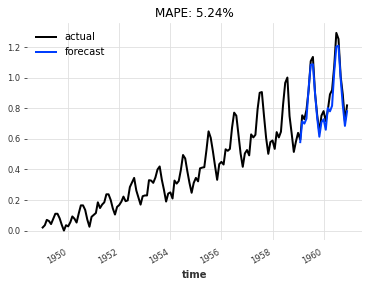

In [11]:
series_transformed.plot(label='actual')
predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(predicted, val_transformed)))
plt.legend()
plt.show()

In [12]:
len(val_transformed)

23